# TEXT2KG Using AMR as Intermediate representation - Clean
[ Insert brief intro to notebook ]
## Loading WikiText Dataset

The first step is loading a dataset containing the article. For our my use case, I will be loading the 'raw' version of WikiText (insertUrl)
by leveraging HuggingFace dataset loader.

In [12]:
from datasets import load_dataset

wikitext_raw = load_dataset("wikitext",'wikitext-2-raw-v1',split='train')
## Print an example line. Index = 1 because index = 0 has an empty string. 

print(wikitext_raw[1]) 

{'text': ' = Valkyria Chronicles III = \n'}


## Extracting the articles' first paragraph and titles
From the experimentation notebook and the information available on the WikiText Markup, we can define a logic that extracts the title and first section of each article from our dataset. 

In [13]:
# Import regular expressions to find Headings, delimited by equal signs: == Heding 2 == etc...
import re 

def extract_articles_info(wikitext, max_articles=None):
    """
    Input: WikiText dataser loaded via 'datasets', optional number of max articles to extract
    Returns: a list with titles, a list with paragraphs, count of articles extracted.
    """
    # Initialize variables for titles and contents
    titles = []
    contents = []
    article_counter = 0

    # Initialize variables for the current article
    content = ''
    # Flag to indicate whether currently processing article content
    in_article = False 

    # Iterate through the dataset
    for row in range(len(wikitext)):
        line = wikitext[row]["text"].strip()
    
        #if line.startswith('=') and we are OUTSIDE of the first section (here just shorthanded to 'article')
        if re.match(r'^= [^=].*?=$', line) and not in_article:
            # If the line starts with exactly one '= ', it's a title
            titles.append(wikitext[row]["text"].strip())
            content = ''
            in_article = True
            article_counter += 1
        elif line.startswith('= = '):
            # If the line starts with exactly two '==', it's the end of the section
            if in_article:
                contents.append(content.strip())
                in_article = False
        
                if max_articles and article_counter >= max_articles:
                    break
        elif in_article:
            # If in_article is True, it means we are still processing article content
            content += wikitext[row]["text"].strip()

    return titles, contents, article_counter 

In [14]:
# Extract the articles
titles, contents, count = extract_articles_info(wikitext_raw)

In [15]:
# To confirm we have extracted everything correctly:
print(titles[0],'\n')
print(contents[0],'\n')
# And check we have the same number of paragraphs as titles
if len(titles)==len(contents):
    print('True')

= Valkyria Chronicles III = 

Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " .The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomer

## Parsing and storing the content.

The plain text paragraphs are the starting point of the actual work. As seen in the experimentation, parsing on paragraph level is not as accurate as on the sentence level (this is not what AMR Parsers are trained for in general), hence we will have to feed sentences from out paragraphs to our parser. To achieve that, nltk tokenizer has been used. Parsing has been processed outside of the notebook and stored for ease of access in the follwing files:
1) paragraph_level_graphs.pk1
2) sentence_level_graphs.pk1
3) sentence_level_graphs_ids.pk1 (updated version of sentence_level_graphs_meta.pk1 that includes id field)

In the next step, a class Document is defined to store each of these as attributes of the class. This will help us building an object that will make it easier to operate on a per-document basis.
We load the files above, together with the plain text paragraphs and sentences:

In [46]:
import nltk 
import pickle
# Importing Vulcan modules to create an object. 
from vulcan.vulcan.pickle_builder.pickle_builder import PickleBuilder
from vulcan.vulcan.data_handling.format_names import FORMAT_NAME_NLTK_TREE, FORMAT_NAME_STRING, FORMAT_NAME_TOKEN, FORMAT_NAME_GRAPH_STRING

# We would like to store, per article:
"""
1. Title
2. Paragraph
3. Paragraph level AMR ( As discussed, this is less accurate but we can store it anyway since we have it.)
4. (Sentence, Sentence AMR)
"""
## Let us create a Class representing each Document

class Document:
    def __init__(self, title, paragraph, paragraph_amr, sentences):
        self.title = title
        self.paragraph = paragraph
        self.paragraph_amr = paragraph_amr
        # Sentences will be a list of 3 tuples with first element plain text and second AMR, third AMR with metadata
        self.sentences = sentences

# Initializing the variables to genereate a Documents objects

titles     = titles   # This is from above 
paragraphs = contents # Also from above
sentences  = [nltk.sent_tokenize(paragraph) for paragraph in contents] # List comprehension to get sentences
# Load pickled data:
with open('paragraph_level_graphs.pk1', 'rb') as file:
    paras_amr = pickle.load(file)
with open('sentence_level_graphs.pk1', 'rb') as file:
    sents_amr = pickle.load(file)
with open('sentence_level_graphs_ids.pk1','rb') as file:
    sents_amr_meta = pickle.load(file)

With all the necessary data loaded, we can iterate over each article and build our document object

In [47]:
all_documents = []

# Messy variable naming!! 
for title, paragraph, p_amr, sents, s_amrs, s_amr_meta in zip(titles, paragraphs, paras_amr, sentences, sents_amr, sents_amr_meta):
    sentences = list(zip(sents, s_amrs, s_amr_meta))
    doc = Document(title, paragraph, p_amr, sentences)
    all_documents.append(doc)
with open("all_documents.pickle", 'wb') as file:
    pickle.dump(all_documents, file)

In [50]:
# Print doc Title
print(all_documents[0].title)
# Print plain text sentence
print(all_documents[0].sentences[2][0])
# Print sentence's AMR with metadata (index 2, change to 1 for no metadata)
print(all_documents[0].sentences[2][2])

= Valkyria Chronicles III =
Released in January 2011 in Japan , it is the third game in the Valkyria series .
# ::id article1.sent3
# ::snt Released in January 2011 in Japan , it is the third game in the Valkyria series .
(g / game
      :ord (o / ordinal-entity
            :value 3)
      :part-of (g2 / game
            :name (n / name
                  :op1 "Valkyria"
                  :op2 "series"))
      :domain (ii / it)
      :ARG1-of (r / release-01
            :location (c / country
                  :name (n2 / name
                        :op1 "Japan"))
            :time (d / date-entity
                  :month 1
                  :year 2011)))


### Next, we store all such data in a format that ca be handled by Vulcan. 
This step can be ignored when rerunning the notebook. 

In [8]:
# Setting up the pickle object. 
pickler = PickleBuilder({"article title": FORMAT_NAME_STRING,
                             "paragraph": FORMAT_NAME_STRING,
                             "paragraph AMR": FORMAT_NAME_GRAPH_STRING,
                             "sentence": FORMAT_NAME_STRING,
                             "sentence AMR": FORMAT_NAME_GRAPH_STRING}
                            )

for doc in all_documents:
    for sent in doc.sentences:
        pickler.add_instances_by_name(
            {"article title": doc.title,
             "paragraph": doc.paragraph,
             "paragraph AMR": doc.paragraph_amr,
             "sentence": sent[0],
             "sentence AMR": sent[1]}
        )
pickler.write('processed_wikitext.pickle')

In [8]:
for doc in all_documents[:10]:
    for sent in doc.sentences[:10]:
        print(sent[0],sent[1])

Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . (t / title-01
      :ARG1 (b / book
            :name (n / name
                  :op1 "Senjō"
                  :op2 "no"
                  :op3 "Valkyria"
                  :op4 3))
      :ARG2 (b2 / book
            :name (n2 / name
                  :op1 "Unrecorded"
                  :op2 "Chronicles")
            :medium (l / language
                  :name (n3 / name
                        :op1 "Japanese"))
            :ARG1-of (l2 / light-04)))
Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . (r / role
      :mod (t / tactic)
      :domain (g / game
            :name (n / name
                  :op1 "Valkyria"
                  :op2 "of"
                  :op3 "the"
                  :op4 "Battlefield"
                  :op5 "3")
            :ARG

# Extracting Triples (DEPRECATED)

With our corpus, we can proceed to define a way to extract all the triples in our AMR graph. This can be accomplished using penman library. 
At a later stage, the Document class can be extended to include the extracted triple, per sentence. For the time being, I will apply this to a single document.


In [49]:
import penman

def triples_extractor(Document):
    """
    input  = a Document object
    output = a list of penman graphs per sentence
    """
    # Keep in mind that penman.decode returns a Graph() object!!
    triples = [penman.decode(sentence[1]) for sentence in Document.sentences]
    
    return triples
document2=all_documents[1]
document1=all_documents[0]
triples = triples_extractor(document1)

# This checks that there is a list of triple for each sentence in the document, which is what we want 
print(len(triples), len(document1.sentences))

print(triples[2].triples)

12 12
[('g', ':instance', 'game'), ('g', ':ord', 'o'), ('o', ':instance', 'ordinal-entity'), ('o', ':value', '3'), ('g2', ':part', 'g'), ('g2', ':instance', 'game'), ('g2', ':name', 'n'), ('n', ':instance', 'name'), ('n', ':op1', '"Valkyria"'), ('n', ':op2', '"series"'), ('g', ':domain', 'ii'), ('ii', ':instance', 'it'), ('r', ':ARG1', 'g'), ('r', ':instance', 'release-01'), ('r', ':location', 'c'), ('c', ':instance', 'country'), ('c', ':name', 'n2'), ('n2', ':instance', 'name'), ('n2', ':op1', '"Japan"'), ('r', ':time', 'd'), ('d', ':instance', 'date-entity'), ('d', ':month', '1'), ('d', ':year', '2011')]


## Mapping Logic
With the triples extracted, we can proceed to iterate a logic that maps our triples to Resource Description Frameork.
To start, we will simply have a 1-to-1 naive mapping, using each Concept or Entity and its relation to Subject, Predicate and Object in RDF. To start with, I have selected the third sentence from the first document. The idea is iterating once sentence at the time, as different instances can be assigned the same placeholder in AMR (n, instance, name) and (n, instance, Nick) in two different sentences

In [99]:
from rdflib import Graph, Namespace
# Yeah i need to make this work later
from ImportantMethods import title2Namespace

# Create RDF graph
graph = Graph()

# Normalzie title to use as Namspace
title = document1.title.replace('=','')
title = title.replace(' ','')
# Define namespaces
ex = Namespace(f"{title}/")

# Iterate over triples in the PenmanGraph
# Naming here is very unelegant and confusing!!
for triple in triples[2].triples:
    # Extract subject, predicate, and object
    subject, predicate, obj = triple

    # Remove double quotes from subjects, predicates, and objects
    subject = subject.replace('"', '')
    predicate = predicate.replace('"', '')
    obj = obj.replace('"', '')
    # Check if the predicate is ':instance'

    # Convert subject, predicate, and object to RDF URIs
    subject_uri = ex[subject]
    predicate_uri = ex[predicate]
    obj_uri = ex[obj]

    # Add triple to RDF graph
    graph.add((subject_uri, predicate_uri, obj_uri))

# Print the RDF triples
for s, p, o in graph:
    print(f"{s} {p} {o}")

ValkyriaChroniclesIII/r ValkyriaChroniclesIII/:ARG1 ValkyriaChroniclesIII/g
ValkyriaChroniclesIII/c ValkyriaChroniclesIII/:name ValkyriaChroniclesIII/n2
ValkyriaChroniclesIII/d ValkyriaChroniclesIII/:instance ValkyriaChroniclesIII/date-entity
ValkyriaChroniclesIII/g ValkyriaChroniclesIII/:ord ValkyriaChroniclesIII/o
ValkyriaChroniclesIII/ii ValkyriaChroniclesIII/:instance ValkyriaChroniclesIII/it
ValkyriaChroniclesIII/d ValkyriaChroniclesIII/:year ValkyriaChroniclesIII/2011
ValkyriaChroniclesIII/n2 ValkyriaChroniclesIII/:instance ValkyriaChroniclesIII/name
ValkyriaChroniclesIII/r ValkyriaChroniclesIII/:location ValkyriaChroniclesIII/c
ValkyriaChroniclesIII/c ValkyriaChroniclesIII/:instance ValkyriaChroniclesIII/country
ValkyriaChroniclesIII/o ValkyriaChroniclesIII/:instance ValkyriaChroniclesIII/ordinal-entity
ValkyriaChroniclesIII/g2 ValkyriaChroniclesIII/:part ValkyriaChroniclesIII/g
ValkyriaChroniclesIII/d ValkyriaChroniclesIII/:month ValkyriaChroniclesIII/1
ValkyriaChroniclesIII/n 

In [97]:
for graph in document1.sentences[2]:
    print(graph)

Released in January 2011 in Japan , it is the third game in the Valkyria series .
(g / game
      :ord (o / ordinal-entity
            :value 3)
      :part-of (g2 / game
            :name (n / name
                  :op1 "Valkyria"
                  :op2 "series"))
      :domain (ii / it)
      :ARG1-of (r / release-01
            :location (c / country
                  :name (n2 / name
                        :op1 "Japan"))
            :time (d / date-entity
                  :month 1
                  :year 2011)))


This approach seems to be working. Let us try and refine the logic. To start, we can collapse the instances nodes. 
To the end of our graph, this are useful to ident...

In [80]:
# Create RDF graph
graph = Graph()

# Normalzie title to use as Namspace
title = document1.title.replace('=','')
title = title.replace(' ','')
# Define namespaces
ex = Namespace(f"{title}/")
#rdf = Namespace("http://www.w3.org/1999/02/22-rdf-syntax-ns#")

instance_mapping = {}  # Dictionary to store the mapping of instances to types

for triple in triples[2].triples:
    # Extract subject, predicate, and object
    subject, predicate, obj = triple

    # Remove double quotes from subjects, predicates, and objects
    subject = subject.replace('"', '')
    predicate = predicate.replace('"', '')
    # Replace column from predicates?
    #predicate = predicate.replace(':', '')
    obj = obj.replace('"', '')

    # Check if the predicate is ':instance'
    if predicate == ':instance':
        instance_mapping[subject] = obj  # Store the mapping of instances to types
    else:
        print(f"Before substitution: {subject} {predicate} {obj}")
        # Substitute instances with their types if available
        subject = instance_mapping.get(subject, subject)
        obj = instance_mapping.get(obj, obj)

        print(f"After substitution: {subject} {predicate} {obj}")
        # Convert subject, predicate, and object to RDF URIs
        subject_uri = ex[subject]
        predicate_uri = ex[predicate]
        obj_uri = ex[obj]

        # Add triple to RDF graph
        graph.add((subject_uri, predicate_uri, obj_uri))

# Print the RDF triples
for s, p, o in graph:
    print(f"{s} {p} {o}")

Before substitution: g :ord o
After substitution: game :ord o
Before substitution: o :value 3
After substitution: ordinal-entity :value 3
Before substitution: g2 :part g
After substitution: g2 :part game
Before substitution: g2 :name n
After substitution: game :name n
Before substitution: n :op1 Valkyria
After substitution: name :op1 Valkyria
Before substitution: n :op2 series
After substitution: name :op2 series
Before substitution: g :domain ii
After substitution: game :domain ii
Before substitution: r :ARG1 g
After substitution: r :ARG1 game
Before substitution: r :location c
After substitution: release-01 :location c
Before substitution: c :name n2
After substitution: country :name n2
Before substitution: n2 :op1 Japan
After substitution: name :op1 Japan
Before substitution: r :time d
After substitution: release-01 :time d
Before substitution: d :month 1
After substitution: date-entity :month 1
Before substitution: d :year 2011
After substitution: date-entity :year 2011
ValkyriaChr

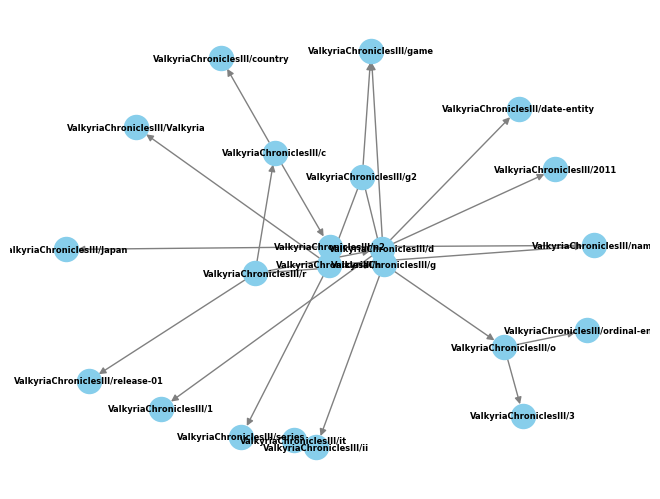

Released in January 2011 in Japan , it is the third game in the Valkyria series .


In [100]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

nx_graph = rdflib_to_networkx_multidigraph(graph)


# Visualize the graph
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, font_weight='bold', node_size=300, node_color="skyblue", font_size=6, edge_color="gray")
plt.show()
print(document1.sentences[2][0])

In [84]:
from pyvis.network import Network
from IPython.display import display, HTML

def visualize_3d_graph_old(graph):
    
    nt = Network(height="750px", width="750px", notebook=True, cdn_resources='remote')
    nt.barnes_hut()
    
    for node in graph.nodes():
        nt.add_node(node, title=str(node))

    for edge in graph.edges():
        print(edge[0], edge[1], edge)
        nt.add_edge(edge[0], edge[1], title=str(edge))
                    
    nt.show_buttons()
    nt.show("Document1.html")
visualize_3d_graph_old(nx_graph)



ValkyriaChroniclesIII/r ValkyriaChroniclesIII/g (rdflib.term.URIRef('ValkyriaChroniclesIII/r'), rdflib.term.URIRef('ValkyriaChroniclesIII/g'))
ValkyriaChroniclesIII/r ValkyriaChroniclesIII/c (rdflib.term.URIRef('ValkyriaChroniclesIII/r'), rdflib.term.URIRef('ValkyriaChroniclesIII/c'))
ValkyriaChroniclesIII/r ValkyriaChroniclesIII/d (rdflib.term.URIRef('ValkyriaChroniclesIII/r'), rdflib.term.URIRef('ValkyriaChroniclesIII/d'))
ValkyriaChroniclesIII/r ValkyriaChroniclesIII/release-01 (rdflib.term.URIRef('ValkyriaChroniclesIII/r'), rdflib.term.URIRef('ValkyriaChroniclesIII/release-01'))
ValkyriaChroniclesIII/g ValkyriaChroniclesIII/o (rdflib.term.URIRef('ValkyriaChroniclesIII/g'), rdflib.term.URIRef('ValkyriaChroniclesIII/o'))
ValkyriaChroniclesIII/g ValkyriaChroniclesIII/game (rdflib.term.URIRef('ValkyriaChroniclesIII/g'), rdflib.term.URIRef('ValkyriaChroniclesIII/game'))
ValkyriaChroniclesIII/g ValkyriaChroniclesIII/ii (rdflib.term.URIRef('ValkyriaChroniclesIII/g'), rdflib.term.URIRef('V

# AMR-LD

With the help of the library AMR-LD, we can store an AMR to an RDF triplestore. This is done (at this stage) via terminal. Here, we load the Turtle file (.n3) containing the RDF instance of our sentences, and create a visual representation of the graph


In [23]:
from pyvis.network import Network
import networkx as nx
import rdflib

def visualize_rdf_graph(rdf_graph):
    # Create a NetworkX graph from RDF
    nx_graph = nx.Graph()
    for s, p, o in rdf_graph:
        nx_graph.add_node(s)
        nx_graph.add_node(o)
        nx_graph.add_edge(s, o, label=p)  # Set the label directly here

    # Create a pyvis network
    nt = Network(height="750px", width="1000px", notebook=True, cdn_resources='remote')
    nt.barnes_hut()

    # Add nodes to the pyvis network
    for node in nx_graph.nodes():
        nt.add_node(node, title=str(node))

    # Add edges to the pyvis network
    for edge in nx_graph.edges(data=True):
        source, target, data = edge
        label = data['label']  # Extract the label from the edge data
        nt.add_edge(source, target, title=str(label))  # Set the title to the label

    nt.show_buttons()
    nt.show("RDF_Visualization.html")

# Load RDF data
rdf_graph = rdflib.Graph()
rdf_graph.parse("test_amrld.n3", format="n3")
visualize_rdf_graph(rdf_graph)


RDF_Visualization.html


Similarly, we can check if and how we can query such file using SPARQL. I have handcrafted the query from the perspective of a user that wants to know where and when the videogame was released. Here's a breief explanation of how the query works:

- The query starts by selecting information about a game's release.
- It begins with the game entity and retrieves its label.
- It then connects to the part of the game (because we know, from graph, that there are g and g2)
- Next, it moves to the release entity associated with the game.
- It retrieves the label of the location where the game was released.
- Finally, it retrieves the month and year of the release date directly from the time entity.

The query has to be handcrafted to reflect the structure of the RDF database and the relationships defined by the AMR meta-model. 

In [32]:
from rdflib import Graph, Namespace

# Load RDF data from a file
file_path = 'test_amrld.n3'  # Adjust the filename accordingly
graph = Graph()
graph.parse(file_path, format='turtle')

# Example SPARQL query
sparql_query = """
    # Select information about a game's release
    SELECT ?gameLabel ?location ?month ?year
    WHERE {
        # Start with the game entity
        ?game a entity-types:game ;
            rdfs:label ?gameLabel ;   # Retrieve the label of the game

            # Connect to the part of the game (again g is part of g2 [or the other way around?]) 
            amr-terms:part ?gamePart .

        # Move to the release entity associated with the game
        ?release a propbank:release-01 ;
            propbank:release-01.ARG1 ?gamePart ;

            # Retrieve the label of the location where the game was released
            amr-terms:location/rdfs:label ?location ;

            # Retrieve the month and year of the release date directly from the time entity
            # remember the slash to traverse directly to a connected node!
            amr-terms:time/amr-terms:month ?month ;
            amr-terms:time/amr-terms:year ?year .
    }
"""


# Execute the query
results = graph.query(sparql_query, initNs={
    'amr-core': Namespace("http://amr.isi.edu/rdf/core-amr#"),
    'amr-terms': Namespace("http://amr.isi.edu/rdf/amr-terms#"),
    'entity-types': Namespace("http://amr.isi.edu/entity-types#"),
    'amr-data': Namespace("http://amr.isi.edu/amr_data#"),
    'propbank': Namespace("http://amr.isi.edu/frames/ld/v1.2.2/")
})

# Print the results
for row in results:
    print(row)


(rdflib.term.Literal('Valkyria series'), rdflib.term.Literal('Japan'), rdflib.term.Literal('1'), rdflib.term.Literal('2011'))
